# Goutham Yegappan Coding Discussion 6
## a.k.a The Predictive Predictor
### a.k.a The Coding Connoisseur
#### a.k.a The Nearest Neighborhood Spider-Man
##### a.k.a The Data Science Scientist

In [1]:
import pandas as pd

data = pd.read_csv('train_data.csv')

In [6]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [7]:
# Load data 
train_data = pd.read_csv("train_data.csv") # Training data
test_data = pd.read_csv("test_data.csv") # Test data 

We can see from the diagram below that the column for yr_rmdl has many missing values

<AxesSubplot:>

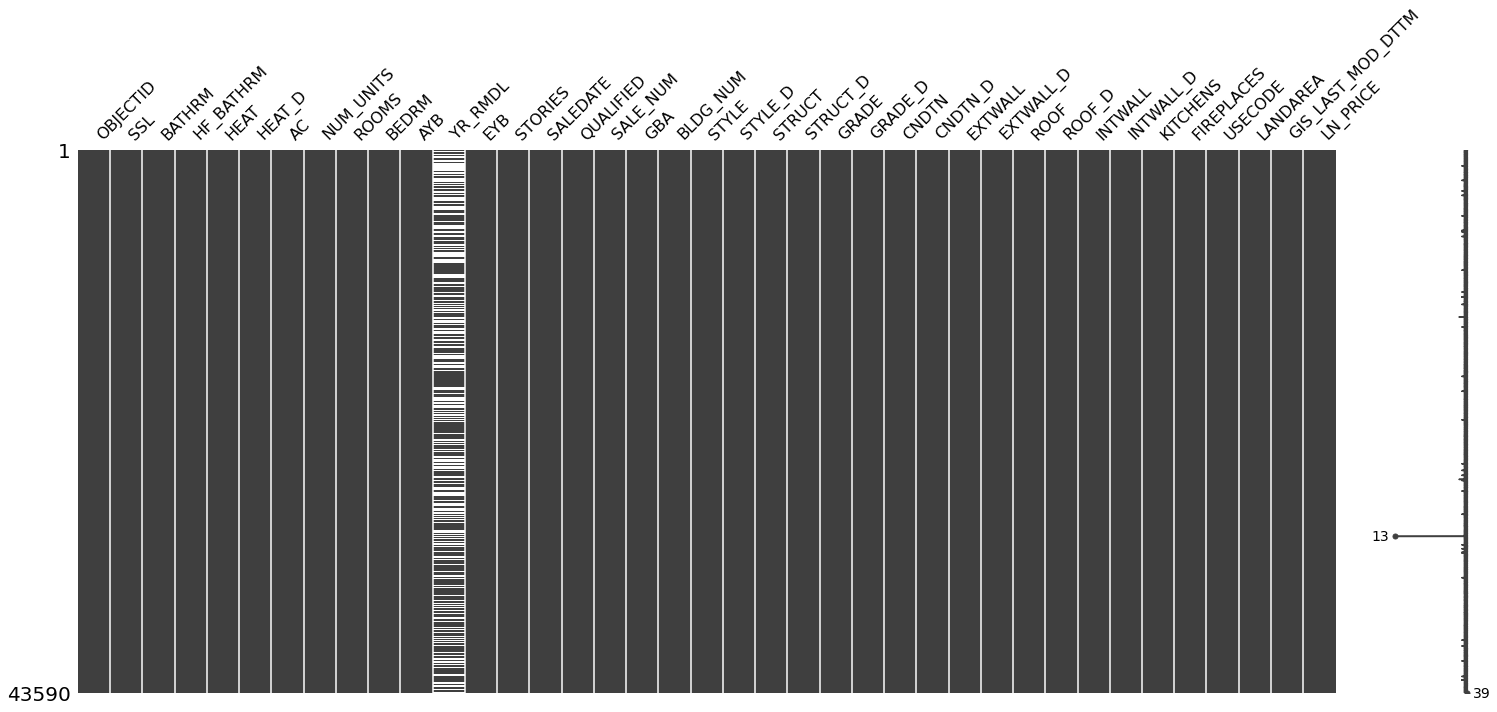

In [10]:
miss.matrix(train_data)

### Clean Data

In [15]:
def clean_data(dta):
    dta = dta.dropna() # Drop missing values 
    dta = dta.replace([np.inf, -np.inf, -0], 0) # Replace float inf with zeroes 

    dta['LANDAREA'] = np.log(dta['LANDAREA']) # Log land area
    return dta

train_data = clean_data(train_data)
test_data = clean_data(test_data)

In [38]:
X = train_data[['BATHRM','ROOMS','LANDAREA']] 
y = train_data['LN_PRICE']


In [39]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1988)

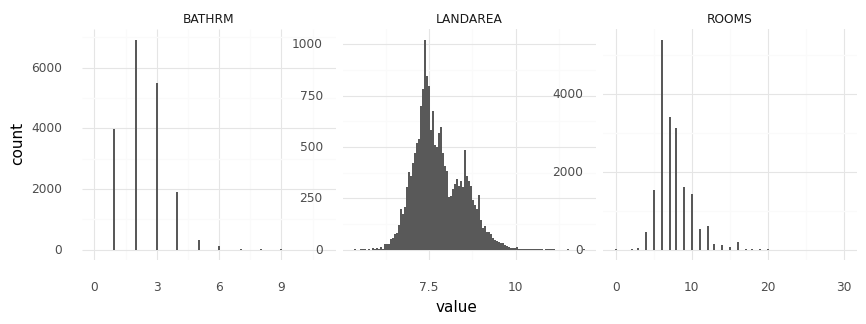

<ggplot: (170035003149)>

In [40]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 

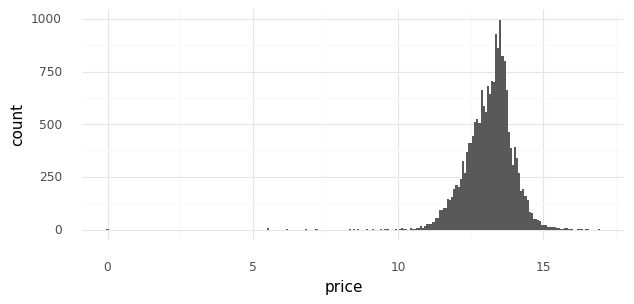

<ggplot: (170035111891)>

In [41]:
(
    ggplot(pd.DataFrame(dict(price=train_y)),
           aes(x="price")) +
    geom_histogram() +
    theme_minimal() +
    theme(figure_size = (7,3)) 
)

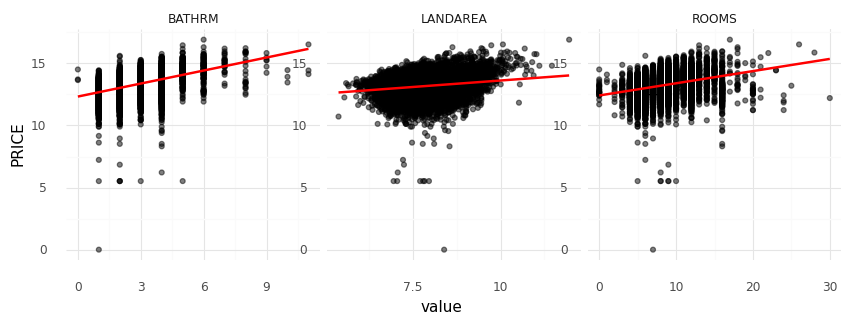

<ggplot: (170035084225)>

In [42]:
D = train_X.copy()
D['PRICE'] = train_y

(
    ggplot(D.melt(id_vars=["PRICE"]),
           aes(x="value",y="PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)


# Pre-Processing The Data

In [43]:
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)


In [44]:
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,BATHRM,ROOMS,LANDAREA
0,0.090909,0.133333,0.383749
1,0.181818,0.233333,0.236738
2,0.454545,0.433333,0.619071
3,0.181818,0.200000,0.204711
4,0.272727,0.300000,0.321383
...,...,...,...
18743,0.181818,0.266667,0.383749
18744,0.272727,0.300000,0.288451
18745,0.181818,0.200000,0.303009
18746,0.181818,0.233333,0.189937


### Modeling

In [46]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)
use_metrics = ["neg_mean_squared_error"]


In [47]:
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)


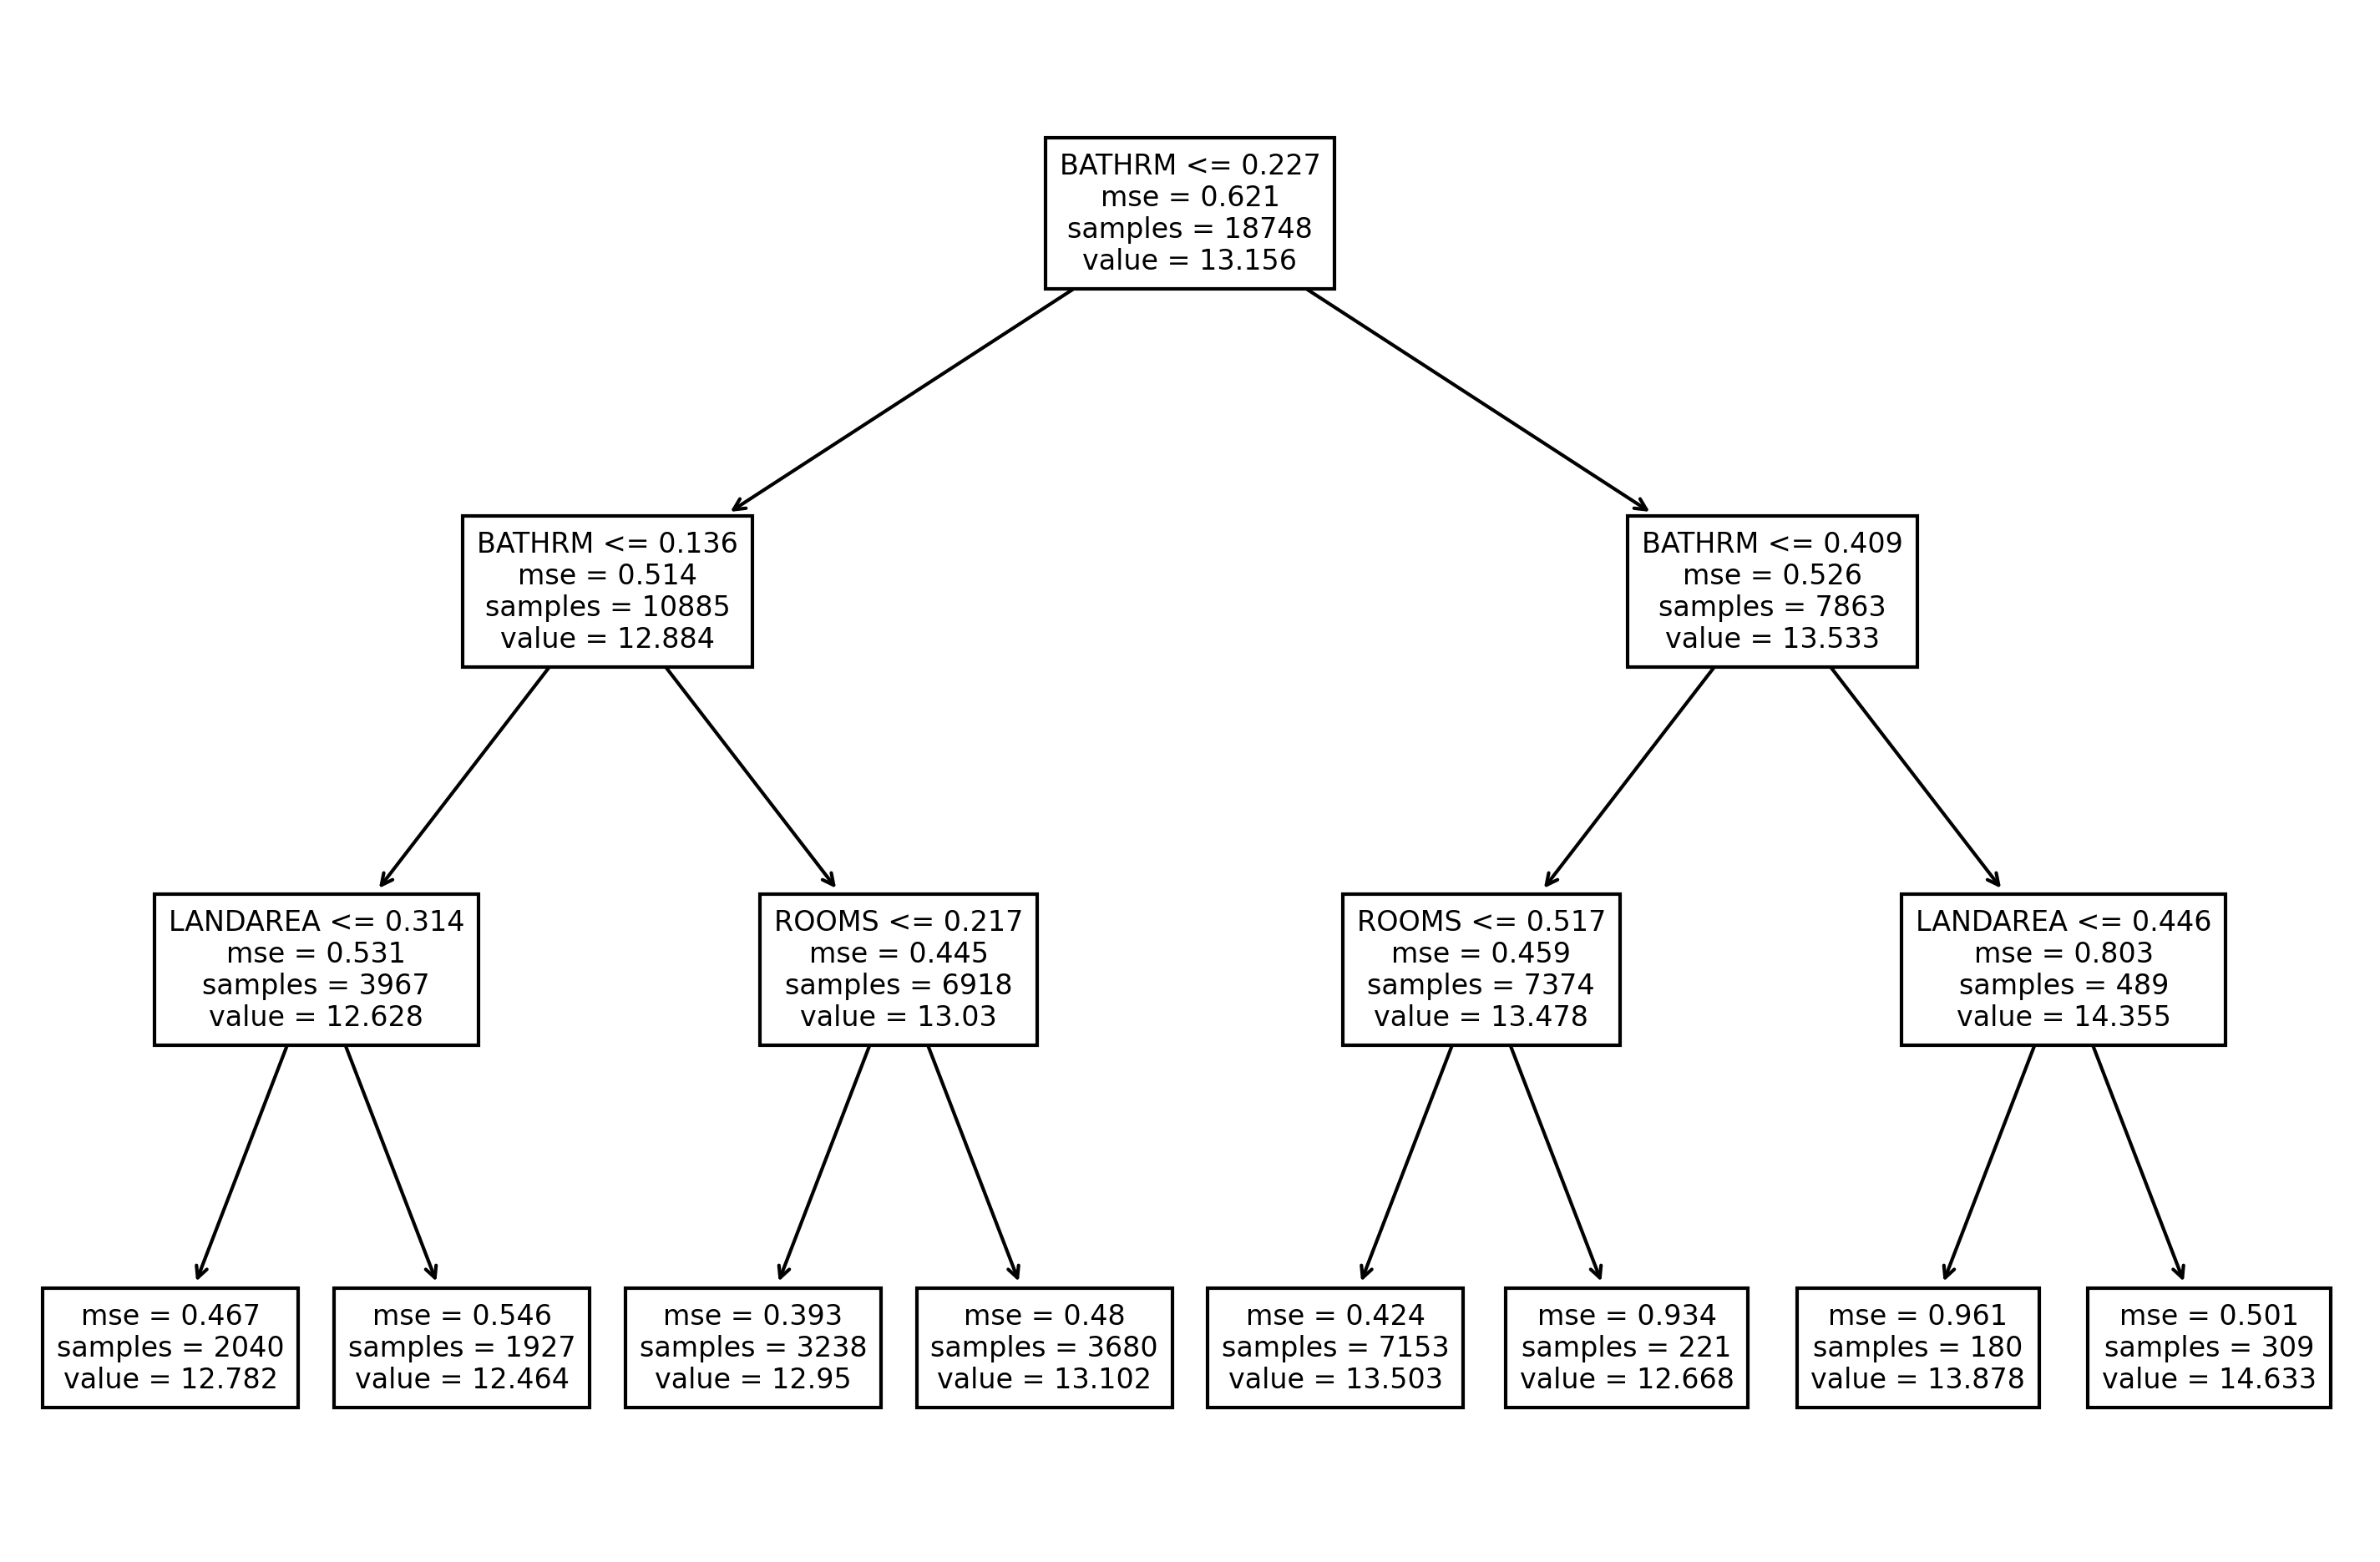

In [48]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X,train_y) # Fit the mode

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=8)

In [49]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)


In [50]:
lm_scores

{'fit_time': array([0.20415354, 0.01600075, 0.018852  , 0.02024364, 0.01567554]),
 'score_time': array([0.0009985 , 0.01681423, 0.        , 0.        , 0.01562214]),
 'test_neg_mean_squared_error': array([-0.46654141, -0.48446822, -0.47374773, -0.45899867, -0.53326719])}

In [51]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores


,Model,MSE
0,lm,0.466541
1,lm,0.484468
2,lm,0.473748
3,lm,0.458999
4,lm,0.533267
5,knn,0.503277
6,knn,0.504013
7,knn,0.489676
8,knn,0.493607
9,knn,0.554230


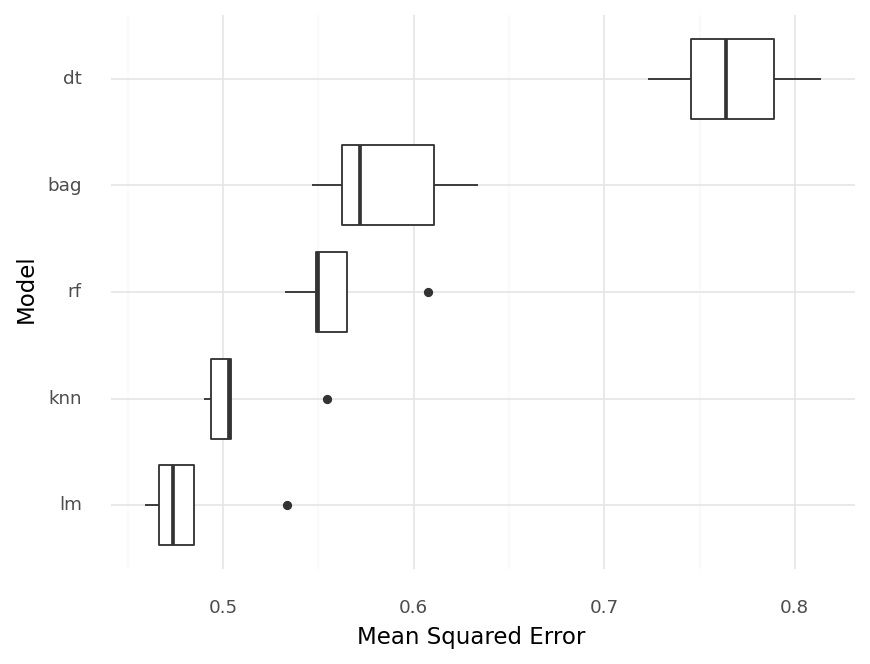

<ggplot: (170034958120)>

In [52]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

From the graph above it is clear that the linear model has the least error thus making it the best model.

In [53]:
set_k = dict()
for k in [1,5,10,50,100,250]:
    score = cross_validate(KNN(n_neighbors=k),
                           train_X,train_y, 
                           cv = fold_generator, 
                           scoring =use_metrics)
    s = score['test_neg_mean_squared_error']
    set_k[k] = s.mean()
 
set_k

{1: -0.8270425388664797,
 5: -0.5089606202920091,
 10: -0.470250371645462,
 50: -0.44180245241025506,
 100: -0.44176945459306516,
 250: -0.44716179994057786}

In [54]:
mod = KNN() # Initialize the model class
mod.get_params() # report all the available tunning parameters 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [55]:
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}


In [56]:
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [57]:
tune_knn.fit(train_X,train_y)


GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [58]:
tune_knn.best_params_


{'n_neighbors': 75}

In [59]:
tune_knn.best_score_


-0.4413270060626859

In [60]:
tune_knn.cv_results_


{'mean_fit_time': array([0.07653618, 0.06910262, 0.07965879, 0.07274666, 0.0716434 ,
        0.07711358, 0.12188272, 0.05926061]),
 'std_fit_time': array([0.02218774, 0.01068432, 0.0083611 , 0.01280213, 0.01311841,
        0.00812794, 0.08030729, 0.01454289]),
 'mean_score_time': array([0.03006773, 0.05615873, 0.08688111, 0.08765469, 0.10133076,
        0.24172025, 0.17829366, 0.32773652]),
 'std_score_time': array([0.00165258, 0.01307156, 0.00973599, 0.00210692, 0.01790981,
        0.09799198, 0.01448113, 0.01789692]),
 'param_n_neighbors': masked_array(data=[1, 10, 25, 35, 50, 75, 100, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 10},
  {'n_neighbors': 25},
  {'n_neighbors': 35},
  {'n_neighbors': 50},
  {'n_neighbors': 75},
  {'n_neighbors': 100},
  {'n_neighbors': 250}],
 'split0_test_score': array([-0.79710416, -0.4617676 , -0.44482009, -0.439

### Tune Parameters For Other Models

In [61]:
DTree().get_params()


{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [62]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [63]:
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [64]:
tune_dt.best_params_


{'max_depth': 5}

In [65]:
tune_dt.best_score_


-0.45031896766834745

The model above performs worse than the previous one.

#### Random Forestssss

In [66]:
RF().get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [67]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]} # Only have three total. 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [68]:
tune_rf.fit(train_X,train_y) 


GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [69]:
tune_rf.best_params_


{'max_depth': 3, 'max_features': 2, 'n_estimators': 1000}

In [70]:
tune_rf.best_score_


-0.45704636610891586

In [71]:
# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1988)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','ROOMS','LANDAREA'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'ROOMS',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [BaggingR

In [72]:
search.best_score_ # Mean out-of-sample (CV) error


-0.446674535959705

In [73]:
search.best_params_


{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

# Time to T- T- T- T- TESTTTTTTTTTTTTTTTTT

In [74]:
pred_y = search.predict(test_X)


In [75]:
m.mean_squared_error(test_y,pred_y)


0.485311119220211

In [76]:
m.r2_score(test_y,pred_y)


0.26776543806237985

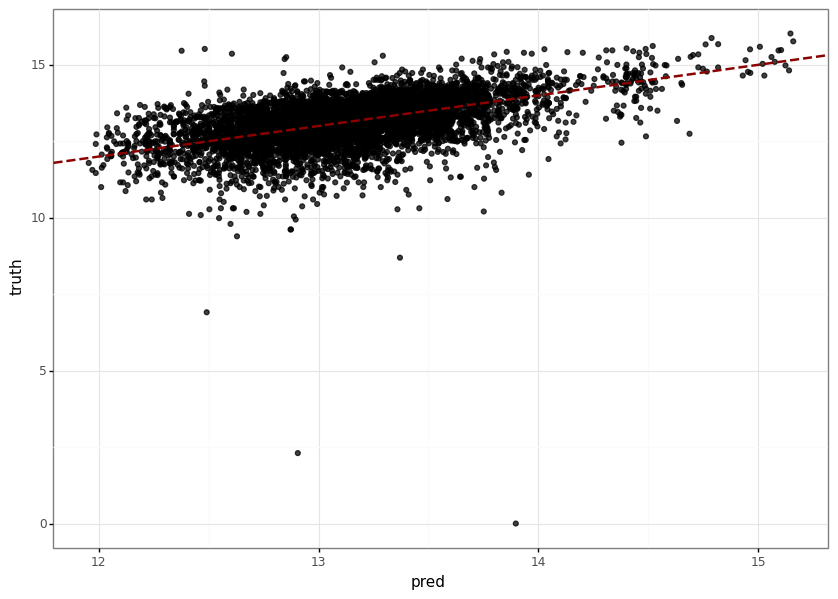

<ggplot: (170036208333)>

In [77]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

Overall these are pretty good results and it is evident from the previous pipeline that the model we are currently using is the best. That being said, ways in which we can improve is to add more variables to our training_data, as well as it would be useful to convert some of the non-integer values into integer values.